In [ ]:
import pandas as pd
import numpy as np

# Load the data
# Assuming 'data.csv' contains the stock prices with a 'Date' column and a 'Close' column
data = pd.read_csv('/content/stock.csv')

# Display the first few rows of the data
print(data.head())


   YEAR  MONTH  DAY    OPEN    HIGH     LOW   CLOSE  VOLUME
0  2020      1    1  125.00  127.50  122.90  125.43   95800
1  2020      1    2  123.15  127.49  123.15  125.84  111600
2  2020      1    3  125.00  125.00  122.00  122.98   66600
3  2020      1    6  120.25  125.00  117.10  119.28  108600
4  2020      1    7  122.00  123.50  113.32  119.26  416300


In [ ]:
# Combine YEAR, MONTH, and DAY into a single Date column
data['Date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']])

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Drop the original YEAR, MONTH, and DAY columns
data.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True)

# Display the first few rows of the modified data
data.head()


,OPEN,HIGH,LOW,CLOSE,VOLUME
Date,,,,,
2020-01-01,125.00,127.50,122.90,125.43,95800
2020-01-02,123.15,127.49,123.15,125.84,111600
2020-01-03,125.00,125.00,122.00,122.98,66600
2020-01-06,120.25,125.00,117.10,119.28,108600
2020-01-07,122.00,123.50,113.32,119.26,416300


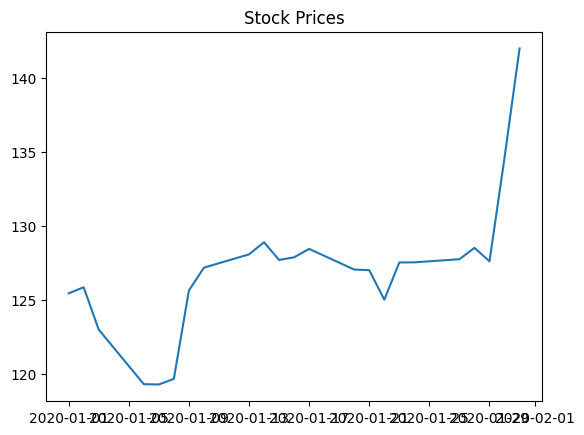

ADF Statistic: 0.6991315202960625
p-value: 0.9898205216618379
Differenced Data ADF Statistic: -2.2350564367191548
Differenced Data p-value: 0.19376883687032853


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Plot the 'Close' prices
plt.plot(data['CLOSE'])
plt.title('Stock Prices')
plt.show()

# Perform Augmented Dickey-Fuller test
result = adfuller(data['CLOSE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, the series is non-stationary and we need to difference it
if result[1] > 0.05:
    diff_data = data['CLOSE'].diff().dropna()
    result = adfuller(diff_data)
    print('Differenced Data ADF Statistic:', result[0])
    print('Differenced Data p-value:', result[1])
else:
    diff_data = data['CLOSE']


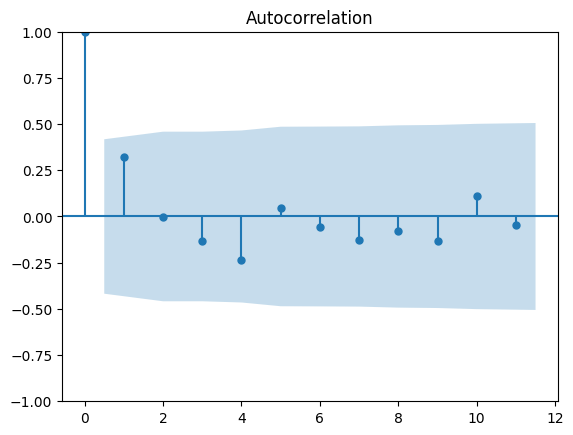

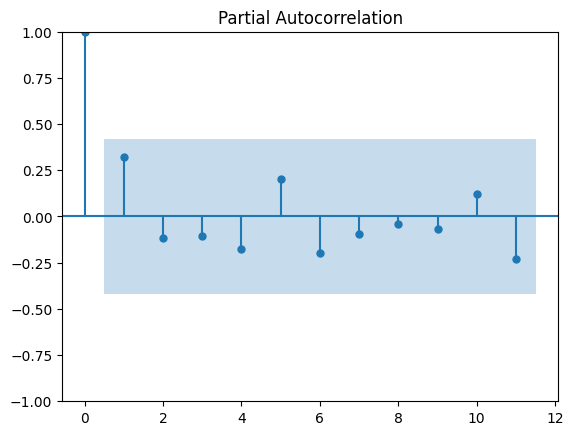

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for differenced data
plot_acf(diff_data)
plot_pacf(diff_data)
plt.show()

# Manually determine p and q from the plots
p = 1  # Example value, to be determined from PACF plot
q = 8  # Example value, to be determined from ACF plot


In [ ]:
import numpy as np
from statsmodels.regression.linear_model import OLS

class ARIMA:
    def __init__(self, data, p, d, q):
        self.data = data
        self.p = p
        self.d = d
        self.q = q

    def fit(self):
        # Differencing
        diff_data = self.data
        for i in range(self.d):
            diff_data = diff_data.diff().dropna()

        # AR part (using OLS regression)
        X = np.column_stack([diff_data.shift(i) for i in range(1, self.p + 1)])
        X = X[self.p:]
        y = diff_data[self.p:]
        self.model_ar = OLS(y, X).fit()

        # MA part (using residuals)
        self.residuals = y - self.model_ar.predict(X)
        self.residuals = self.residuals[self.q:]

        X_residuals = np.column_stack([self.residuals.shift(i) for i in range(1, self.q + 1)])
        X_residuals = X_residuals[self.q:]
        y_residuals = self.residuals[self.q:]

        self.model_ma = OLS(y_residuals, X_residuals).fit()

    def predict(self, steps):
        # Make predictions
        predictions = []
        last_data = self.data[-self.p:]
        for i in range(steps):
            ar_part = np.dot(self.model_ar.params, last_data[-self.p:])
            ma_part = np.dot(self.model_ma.params, self.residuals[-self.q:])
            prediction = ar_part + ma_part
            predictions.append(prediction)

            # Update data for next prediction
            last_data = np.append(last_data, prediction)
            self.residuals = np.append(self.residuals, prediction - ar_part)

        return predictions

# Fit the model
arima = ARIMA(data['CLOSE'], p=p, d=2, q=q)
arima.fit()

# Make predictions
predictions = arima.predict(steps=10)
print(predictions)


[-50.31311466053836, 17.336857227479623, 8.36115706625186, -4.363385658267914, -11.490665875680072, 8.035039590024498, 31.46838139981995, -27.58652770891539, -22.258816566715225, 28.928833418444434]


              OPEN    HIGH     LOW   CLOSE  VOLUME
Date                                              
2020-01-01  125.00  127.50  122.90  125.43   95800
2020-01-02  123.15  127.49  123.15  125.84  111600
2020-01-03  125.00  125.00  122.00  122.98   66600
2020-01-06  120.25  125.00  117.10  119.28  108600
2020-01-07  122.00  123.50  113.32  119.26  416300


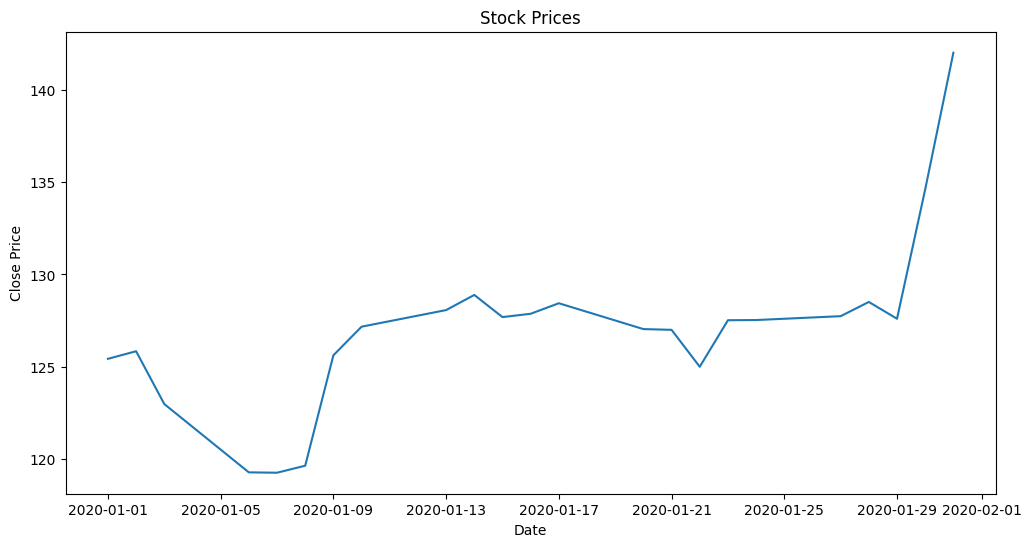

ADF Statistic: 0.6991315202960625
p-value: 0.9898205216618379
Differenced Data ADF Statistic: -2.2350564367191548
Differenced Data p-value: 0.19376883687032853


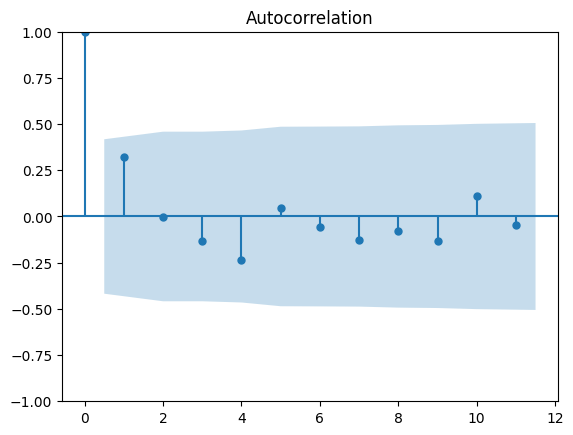

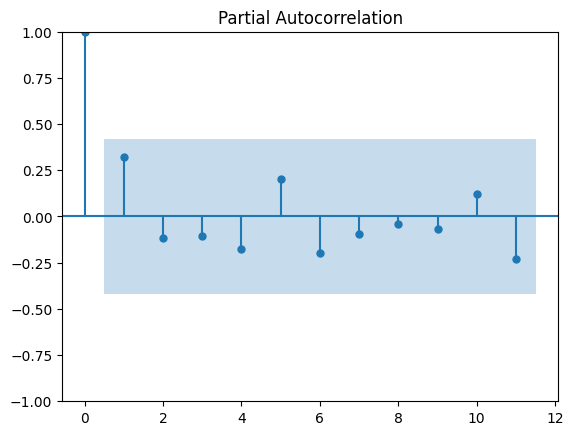

[-46.38172850410329, 14.48797418388598, -4.3493683848792655, 1.3653666497508241, -0.46269966116499733, 0.1524385496069336, -0.04482723663441686, 0.012811136107883637, -0.004315955778328775, 0.001595606900967913]


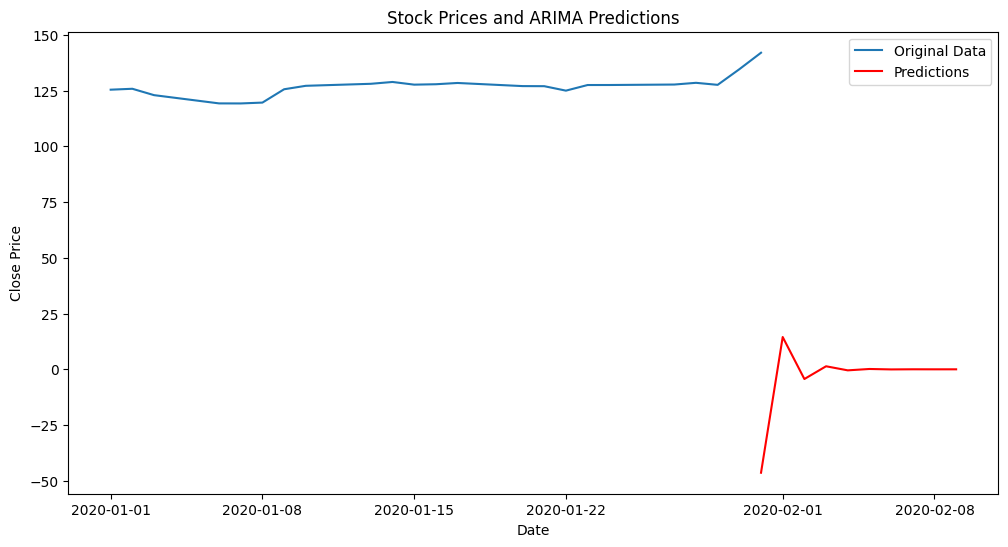

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS

# Load the data
file_path = '/content/stock.csv'
data = pd.read_csv(file_path, parse_dates=[['YEAR', 'MONTH', 'DAY']], index_col='YEAR_MONTH_DAY')
data.index.names = ['Date']

# Display the first few rows of the data
print(data.head())

# Plot the 'Close' prices
plt.figure(figsize=(12, 6))
plt.plot(data['CLOSE'])
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Perform Augmented Dickey-Fuller test
result = adfuller(data['CLOSE'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, the series is non-stationary and we need to difference it
if result[1] > 0.05:
    diff_data = data['CLOSE'].diff().dropna()
    result = adfuller(diff_data)
    print('Differenced Data ADF Statistic:', result[0])
    print('Differenced Data p-value:', result[1])
else:
    diff_data = data['CLOSE']

# Plot ACF and PACF for differenced data
plot_acf(diff_data)
plot_pacf(diff_data)
plt.show()

# Determine p and q from the plots (Example values)
p = 1
q = 2

class ARIMA:
    def __init__(self, data, p, d, q):
        self.data = data
        self.p = p
        self.d = d
        self.q = q

    def fit(self):
        # Differencing
        diff_data = self.data
        for i in range(self.d):
            diff_data = diff_data.diff().dropna()

        # AR part (using OLS regression)
        X = np.column_stack([diff_data.shift(i) for i in range(1, self.p + 1)])
        X = X[self.p:]
        y = diff_data[self.p:]
        self.model_ar = OLS(y, X).fit()

        # MA part (using residuals)
        self.residuals = y - self.model_ar.predict(X)
        self.residuals = self.residuals[self.q:]

        X_residuals = np.column_stack([self.residuals.shift(i) for i in range(1, self.q + 1)])
        X_residuals = X_residuals[self.q:]
        y_residuals = self.residuals[self.q:]

        self.model_ma = OLS(y_residuals, X_residuals).fit()

    def predict(self, steps):
        # Make predictions
        predictions = []
        last_data = self.data[-self.p:]
        for i in range(steps):
            ar_part = np.dot(self.model_ar.params, last_data[-self.p:])
            ma_part = np.dot(self.model_ma.params, self.residuals[-self.q:])
            prediction = ar_part + ma_part
            predictions.append(prediction)

            # Update data for next prediction
            last_data = np.append(last_data, prediction)
            self.residuals = np.append(self.residuals, prediction - ar_part)

        return predictions

# Fit the model
arima = ARIMA(data['CLOSE'], p=p, d=2, q=q)
arima.fit()

# Make predictions
steps =10
predictions = arima.predict(steps=steps)
print(predictions)

# Create a new DataFrame for plotting
pred_dates = pd.date_range(start=data.index[-1], periods=steps)
pred_series = pd.Series(predictions, index=pred_dates)

# Plot the original data and the predictions
plt.figure(figsize=(12, 6))
plt.plot(data['CLOSE'], label='Original Data')
plt.plot(pred_series, label='Predictions', color='red')
plt.title('Stock Prices and ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# **USING LIBRARY:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

data = pd.read_csv('/content/stock.csv')

# Display the first few rows of the data
print(data.head())

data = data[["CLOSE"]].copy()
data.describe()

result = adfuller(data.CLOSE.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')



   YEAR  MONTH  DAY    OPEN    HIGH     LOW   CLOSE  VOLUME
0  2020      1    1  125.00  127.50  122.90  125.43   95800
1  2020      1    2  123.15  127.49  123.15  125.84  111600
2  2020      1    3  125.00  125.00  122.00  122.98   66600
3  2020      1    6  120.25  125.00  117.10  119.28  108600
4  2020      1    7  122.00  123.50  113.32  119.26  416300
ADF Statistic: 0.6991315202960625
p-value: 0.9898205216618379


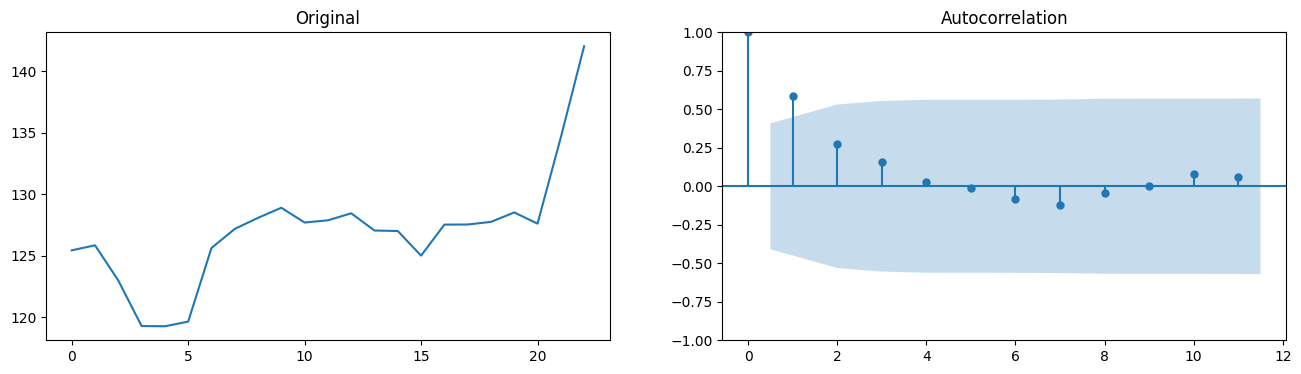

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(data.CLOSE)
ax1.set_title("Original")
plot_acf(data.CLOSE, ax=ax2);

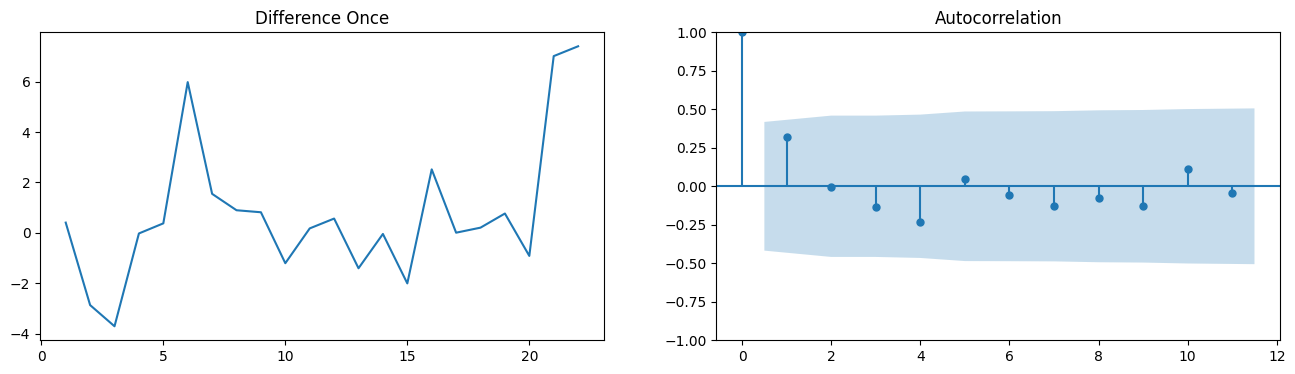

In [ ]:
diff = data.CLOSE.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax=ax2);

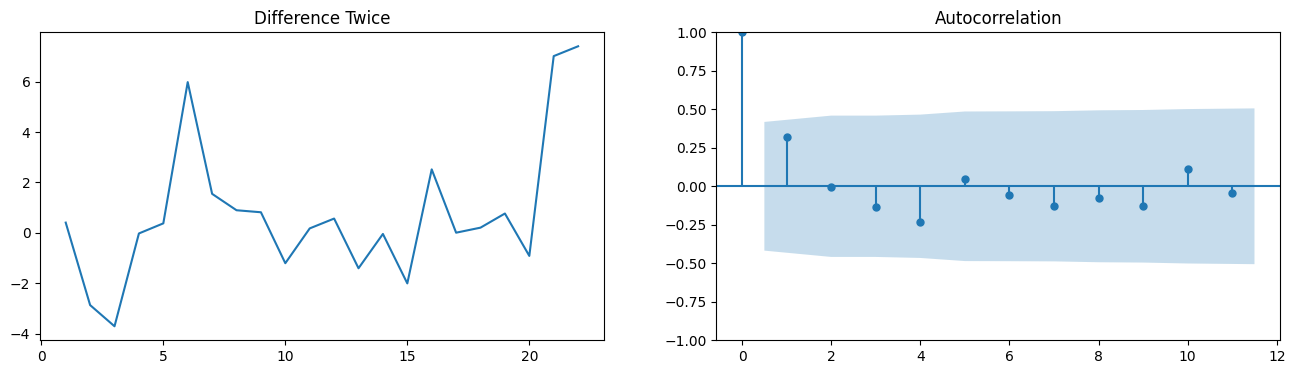

In [ ]:
diff = data.CLOSE.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Twice")
plot_acf(diff, ax=ax2);

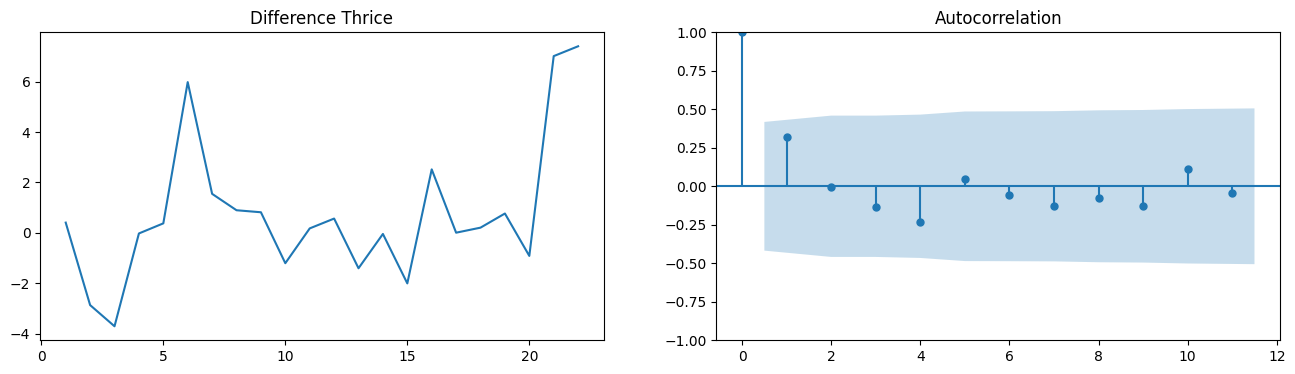

In [ ]:
diff = data.CLOSE.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Thrice")
plot_acf(diff, ax=ax2);

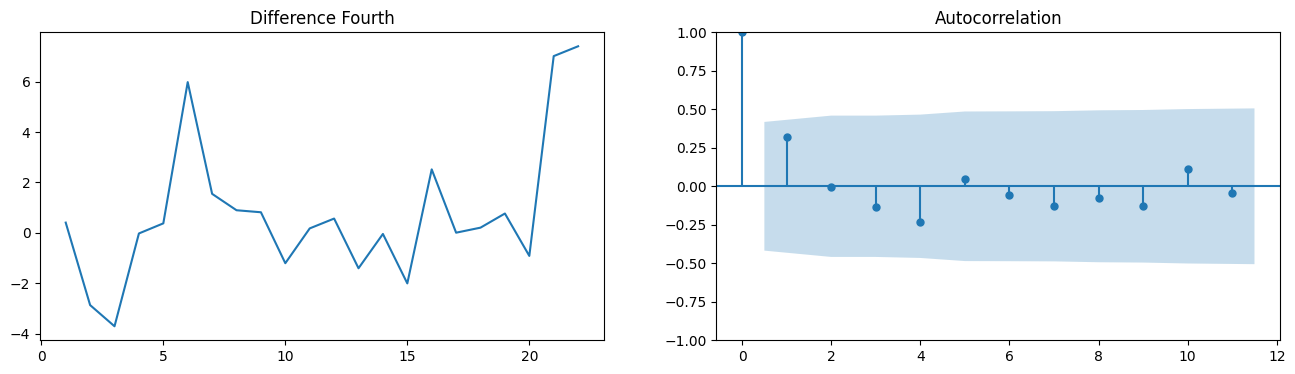

In [ ]:
diff = data.CLOSE.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Fourth")
plot_acf(diff, ax=ax2);

In [ ]:
!pip install pmdarima
from pmdarima.arima import ndiffs # Now the module should be available

In [ ]:
ndiffs(data.CLOSE, test="adf")

2

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

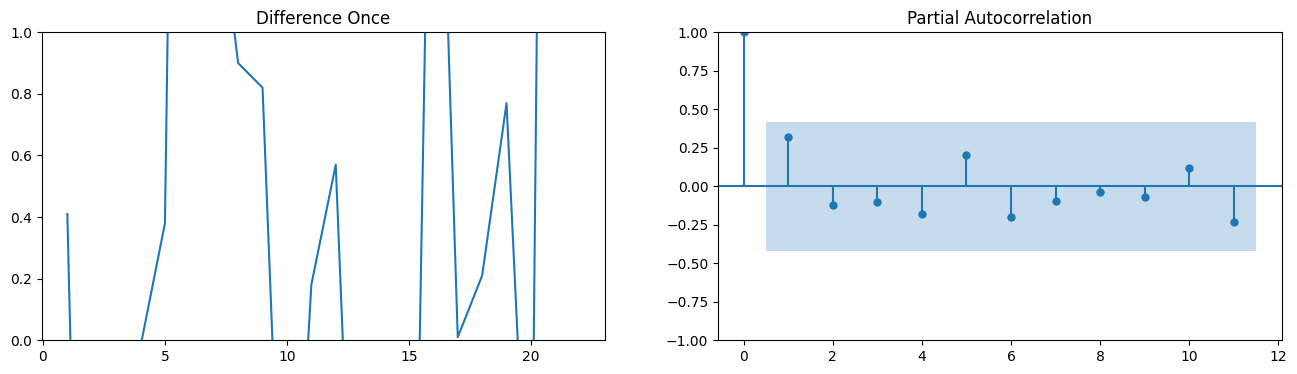

In [ ]:
diff = data.CLOSE.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Difference Once")
ax1.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

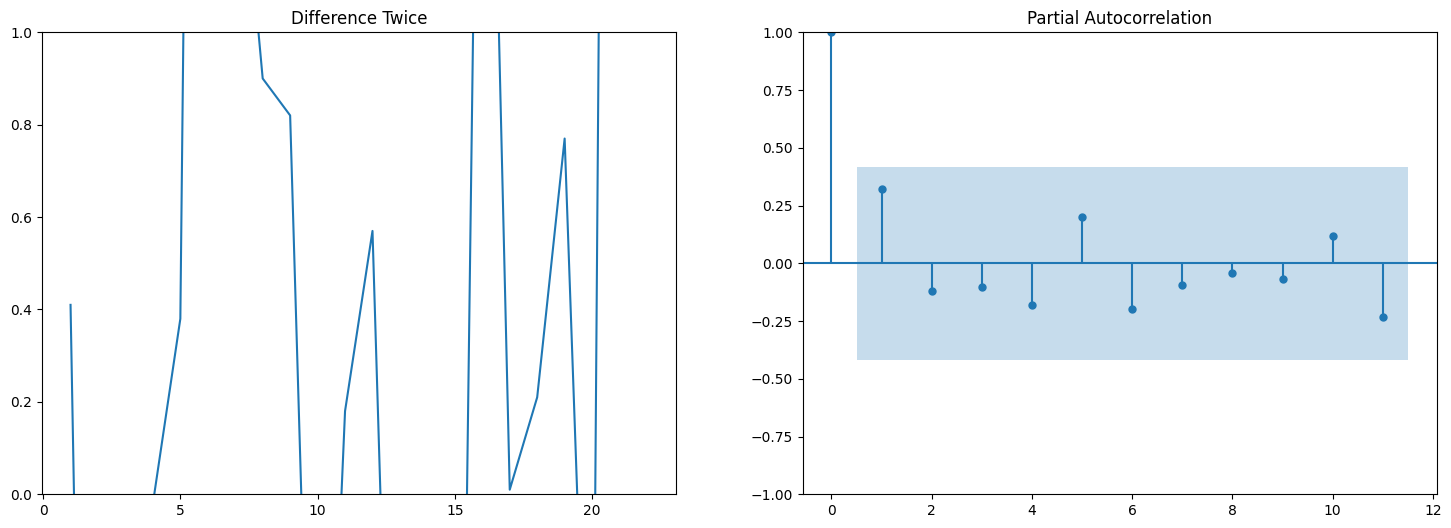

In [ ]:
diff = data.CLOSE.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (18,6))

ax1.plot(diff)
ax1.set_title("Difference Twice")
ax1.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
 # Import from the correct module

model = ARIMA(data.CLOSE, order=(5,2,0))
result = model.fit()

In [ ]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                   23
Model:                 ARIMA(5, 2, 0)   Log Likelihood                 -47.423
Date:                Wed, 26 Jun 2024   AIC                            106.846
Time:                        18:59:40   BIC                            113.114
Sample:                             0   HQIC                           108.207
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1494      0.259     -0.578      0.563      -0.656       0.358
ar.L2          0.1086      0.393      0.276      0.782      -0.662       0.880
ar.L3         -0.2929      0.386     -0.760      0.4

(array([0.00231594, 0.        , 0.        , 0.04863467, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00231594]),
 array([-62.30511832, -43.53160649, -24.75809466,  -5.98458282,
         12.78892901,  31.56244084,  50.33595267,  69.1094645 ,
         87.88297634, 106.65648817, 125.43      ]),
 <BarContainer object of 10 artists>)

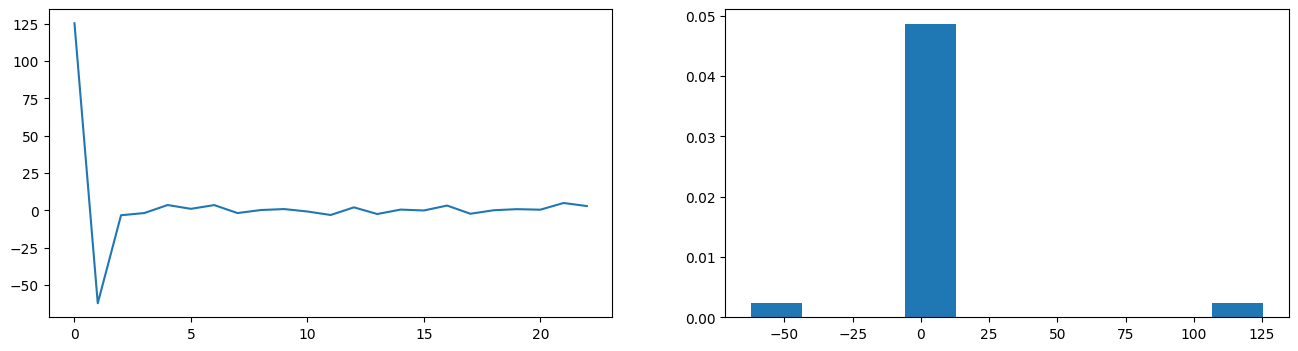

In [ ]:
residuals = pd.DataFrame(result.resid)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,4))

ax1.plot(residuals)
ax2.hist(residuals, density = True)


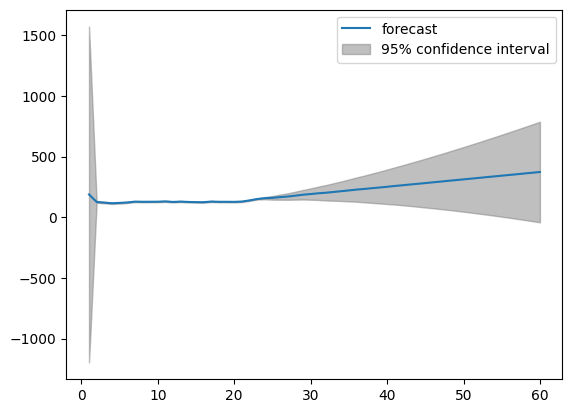

In [ ]:

# Import the necessary plotting functionality
from statsmodels.graphics.tsaplots import plot_predict

# Use the plot_predict function directly, passing in the fitted result object and desired parameters
plot_predict(
    result,  # Pass the result object, not result.model
    start=1,
    end=60,
    dynamic=False,
)
plt.show()


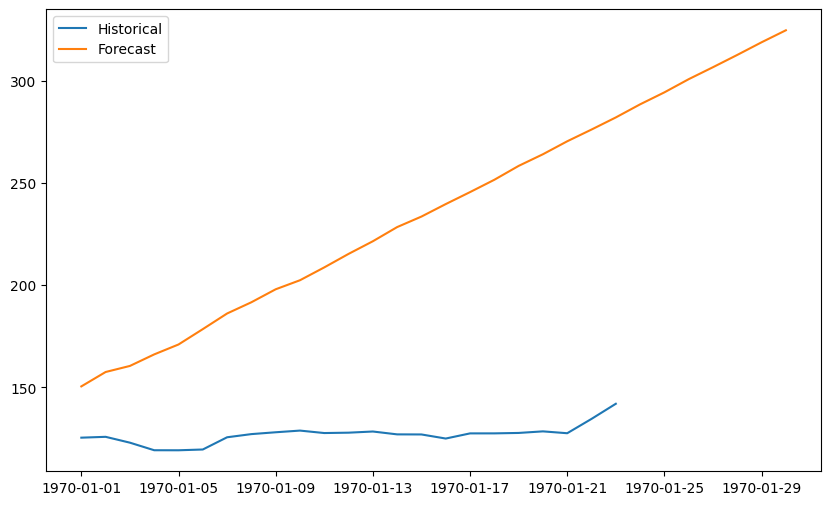

In [ ]:
forecast = result.forecast(steps=30)
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['CLOSE'], label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='D'), forecast, label='Forecast')
plt.legend()
plt.show()

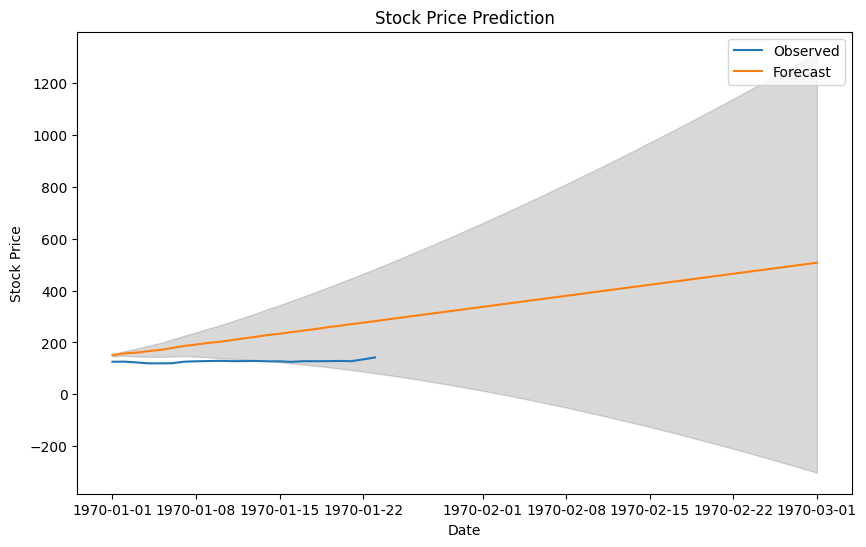

In [ ]:
forecast_steps = 60
forecast = result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['CLOSE'], label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='gray', alpha=0.3)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# **2nd Implementation:**

            MONTH  DAY    OPEN    HIGH     LOW   CLOSE  VOLUME
YEAR                                                          
2020-01-01      1    1  125.00  127.50  122.90  125.43   95800
2020-01-01      1    2  123.15  127.49  123.15  125.84  111600
2020-01-01      1    3  125.00  125.00  122.00  122.98   66600
2020-01-01      1    6  120.25  125.00  117.10  119.28  108600
2020-01-01      1    7  122.00  123.50  113.32  119.26  416300


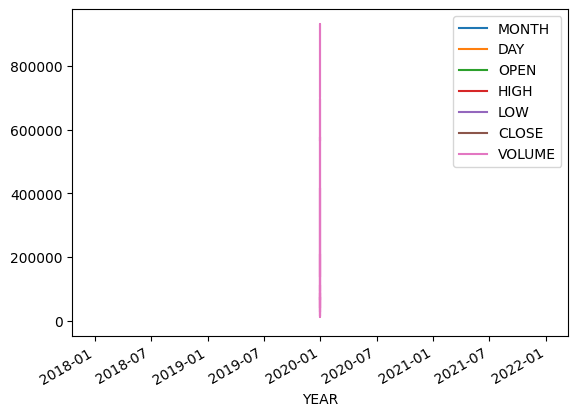

In [ ]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('/content/stock.csv', header=0, parse_dates=[0], index_col=0)
print(series.head())
series.plot()
pyplot.show()

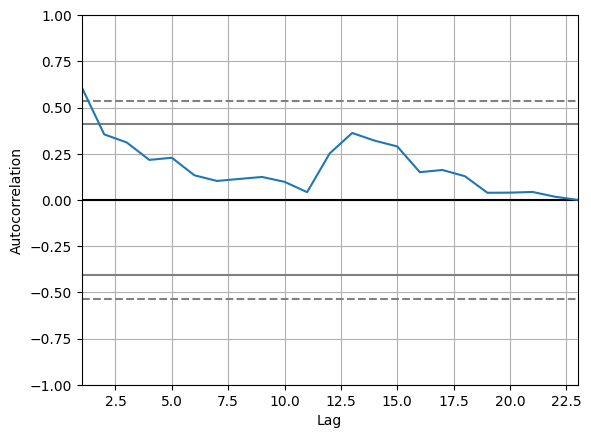

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
pyplot.show()

predicted=125.825137, expected=125.000000
predicted=123.960143, expected=127.520000
predicted=128.745515, expected=127.530000
predicted=128.736676, expected=127.740000
predicted=127.410809, expected=128.510000
predicted=127.028409, expected=127.600000
predicted=128.731913, expected=134.610000
predicted=137.577180, expected=142.010000
Test RMSE: 2.991


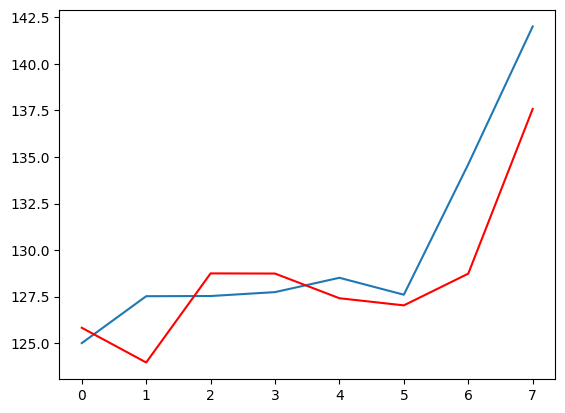

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset

series = read_csv('/content/stock.csv', header=0, index_col=0, parse_dates=True)
series.index = series.index.to_period('M')
# Select a single column for univariate analysis
# Assuming 'CLOSE' is the column you want to predict
series = series['CLOSE']
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()